In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

connct = psycopg2.connect('dbname=WhiskyAdvocate user= postgres password = [redacted] host = 127.0.0.1 port=5432')

#Query the database to recover the needed data for unsupervised learning operations

ds_query = ''' SELECT whiskey_id, fruity_words, wood_words, spicy_words, sweet_words, maillard_words, smoke_words
                FROM features_rev'''

ml_df_full = pd.read_sql(ds_query, connct)

ml_df_full.head()

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
0           0             2           1            2            0   
1           1             2           0            0            1   
2           2             1           2            1            1   
3           3             1           0            0            3   
4           4             2           0            0            3   

   maillard_words  smoke_words  
0               0            0  
1               2            0  
2               1            0  
3               0            0  
4               1            0

In [2]:
#connct.close()

I am choosing DBSCAN for clustering analysis because there are a lot of points that look like noise points, and a lot of the points look like noise points. Kmeans and agglomerative clustering are bad for irregular shaped clusters. 

In [3]:
#git rid of whiskey_id

ml_df = ml_df_full.drop(['whiskey_id'], axis = 1)

#check for missing values
ml_df.isnull().sum()

fruity_words      0
wood_words        0
spicy_words       0
sweet_words       0
maillard_words    0
smoke_words       0
dtype: int64

In [4]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900 entries, 0 to 5899
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   fruity_words    5900 non-null   int64
 1   wood_words      5900 non-null   int64
 2   spicy_words     5900 non-null   int64
 3   sweet_words     5900 non-null   int64
 4   maillard_words  5900 non-null   int64
 5   smoke_words     5900 non-null   int64
dtypes: int64(6)
memory usage: 276.7 KB


I am going to try implementing the DBSCAN clustering alogrythm using scikit learn. I have questions about how well it will work. If it doesn't work, I don't think other clustering algorythms are necessarily likely to work better because of the irregular appearance of some of the clusters when I run t-SNE. An idea I have for refactoring the project is to combine features that seem related - for instance sugar, sweet and honey could all go in the same features, and some of the fruit descriptors could be summed in another feature. This reduceds the dimensionality of the feature space along defensible lines, and may make it easier to spot clusters and patterns.  

In [5]:
#import some necessary things from sklearn

import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN


In [6]:
#scale the data using minmaxscaler

scaler = MinMaxScaler().fit(ml_df)

ml_scale = scaler.transform(ml_df)

ml_scale

array([[0.18181818, 0.125     , 0.25      , 0.        , 0.        ,
        0.        ],
       [0.18181818, 0.        , 0.        , 0.16666667, 0.25      ,
        0.        ],
       [0.09090909, 0.25      , 0.125     , 0.16666667, 0.125     ,
        0.        ],
       ...,
       [0.09090909, 0.        , 0.25      , 0.16666667, 0.25      ,
        0.        ],
       [0.09090909, 0.        , 0.        , 0.        , 0.25      ,
        0.        ],
       [0.18181818, 0.125     , 0.        , 0.        , 0.375     ,
        0.        ]])

In [7]:
#I used min max scaler, which should put all the features between 0 and 1. this means my epsilon (neighborhood) value for 
#DBSCAN needs to be small. I'm going to start with 0.05
#min samples should be kind of large because there are 5900 points in the set. 25 seems like a reasonable value to start. 

cls_1 = DBSCAN(eps = 0.1, min_samples = 25).fit_predict(ml_scale)

cls_1

array([ 0, -1,  1, ..., -1, 30, -1], dtype=int64)

In [8]:
# my preferred t-SNE parameters were tsne15 = TSNE(random_state=42, perplexity = 40, learning_rate = 1000)
#copying over my helpful t-SNE functions for visualizing my clustering

def tsne_unpack(tsne_array, list1, list2):
    for t in tsne_array:
        list1.append(t[0])
        list2.append(t[1])

def visny_tsne(tsne_instantiation):
    
    ws_tsne_iter = tsne_instantiation.fit_transform(ml_scale)
    
    tsne_x = []
    tsne_y = []
    
    tsne_unpack(ws_tsne_iter, tsne_x, tsne_y)
    
    plt.figure(figsize = (12, 12))
    sns.scatterplot(x = tsne_x, y = tsne_y)
    plt.show()


In [9]:
#constructing a dataframe for t-SNE visualization of clustering
pref_tsne = TSNE(random_state=42, perplexity = 50, learning_rate = 1000, early_exaggeration = 30)

db_tsne1 = pref_tsne.fit_transform(ml_scale)

pref_tsne_x = []
pref_tsne_y = []

tsne_unpack(db_tsne1, pref_tsne_x, pref_tsne_y)

vis1_dict = {'tSNE_x': pref_tsne_x, 'tSNE_y':pref_tsne_y}

vis_1 = pd.DataFrame(vis1_dict)

vis_1.head()

tSNE_x     tSNE_y
0  17.502785  56.396896
1   5.344396 -61.841087
2 -38.810066 -10.793710
3 -33.354923 -68.098503
4 -34.349125 -66.084190

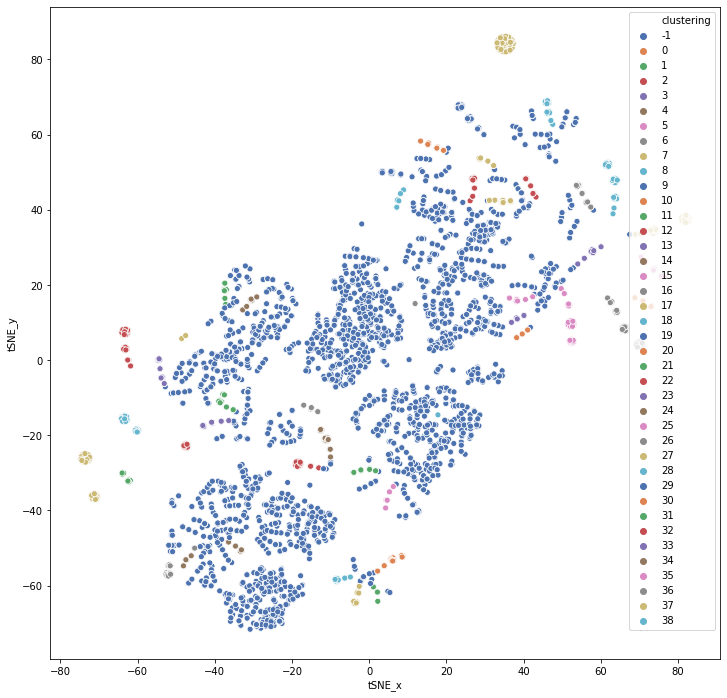

In [10]:
# adding clustering data as a new column, and visualizing

vis_1['clustering'] = cls_1

plt.figure(figsize = (12, 12))
sns.scatterplot(data = vis_1, x = 'tSNE_x', y = 'tSNE_y', hue = 'clustering', palette = 'deep')

plt.show()

Lots of little clusters. Needs optimization, but we might get something like this. 

In [11]:
# I am going to use the elbow method for deciding my epsilon value
# I used a similar method to Chelsea Pelleriti https://www.youtube.com/watch?v=0V2r7SGP2ZM

from sklearn.neighbors import NearestNeighbors

#set mins argument (what distance do you want nearest neighbors to go by)
# I will start with 25 but may reduce this number
mins = 25

nn = NearestNeighbors(mins + 1)

nn.fit(ml_scale)

distances, neighbors = nn.kneighbors(ml_scale)

distances

C:\Users\gspah\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([[0.        , 0.        , 0.        , ..., 0.09090909, 0.09090909,
        0.09090909],
       [0.        , 0.        , 0.        , ..., 0.125     , 0.125     ,
        0.125     ],
       [0.        , 0.        , 0.        , ..., 0.09090909, 0.09090909,
        0.09090909],
       ...,
       [0.        , 0.        , 0.        , ..., 0.125     , 0.125     ,
        0.125     ],
       [0.        , 0.        , 0.        , ..., 0.09090909, 0.09090909,
        0.09090909],
       [0.        , 0.        , 0.        , ..., 0.125     , 0.125     ,
        0.14285714]])

In [12]:
len(distances)

5900

In [13]:
distances = np.sort(distances[:, mins], axis = 0)

distances

array([0.        , 0.        , 0.        , ..., 0.57099438, 0.61237244,
       0.86435773])

In [14]:
len(distances)

5900

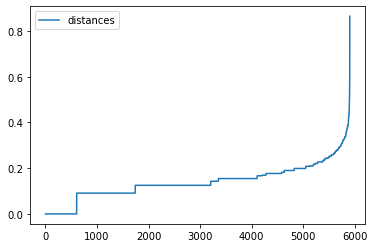

In [15]:
distance_df = pd.DataFrame({'distances':distances})

distance_df.plot(kind = 'line')

C:\Users\gspah\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


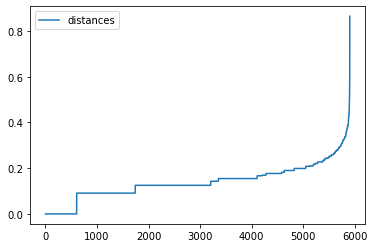

In [16]:
#code out a function to look at how this works for a few different values of mins

def elbow_fxn(min_nearest_neighbors):
    nns = NearestNeighbors(min_nearest_neighbors + 1)
    nns.fit(ml_scale)
    dist, neigh = nns.kneighbors(ml_scale)
    dist = np.sort(dist[:, min_nearest_neighbors], axis = 0)
    dist_df = pd.DataFrame({'distances': dist})
    dist_df.plot(kind = 'line')
    plt.show()

elbow_fxn(25)


C:\Users\gspah\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=11 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


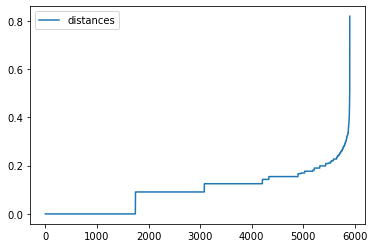

In [17]:
elbow_fxn(10)

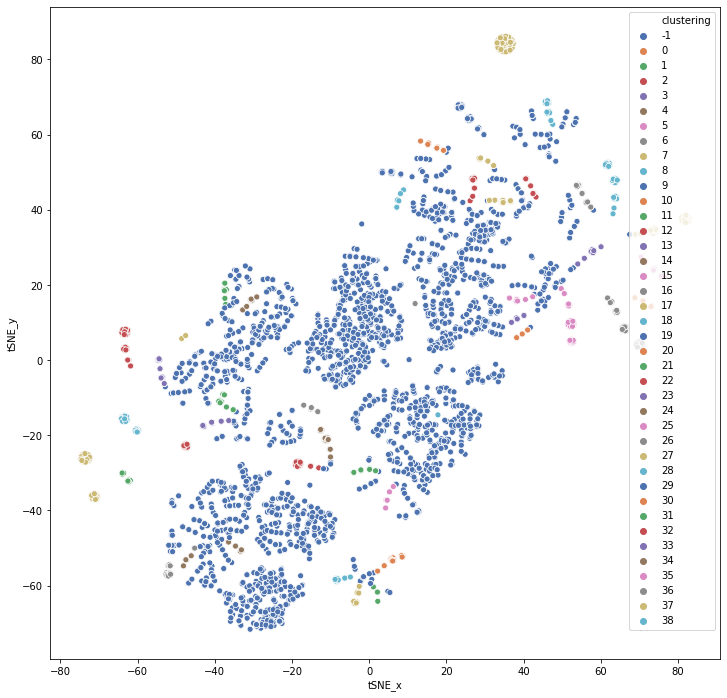

In [18]:
#elbow function is different, but still not sure I've got it right. I'm going to try a few new values for clustering (again) though, 
#based on the scales I'm seeing. 

cls_2 = DBSCAN(eps = 0.1, min_samples = 25).fit_predict(ml_scale)

#write a function to make visualizing clustering results on the t-SNE picture really easy

def cluster_vis(dbscan_array):
    vis_1['clustering'] = dbscan_array

    plt.figure(figsize = (12, 12))
    sns.scatterplot(data = vis_1, x = 'tSNE_x', y = 'tSNE_y', hue = 'clustering', palette = 'deep')

    plt.show()

cluster_vis(cls_2)
    

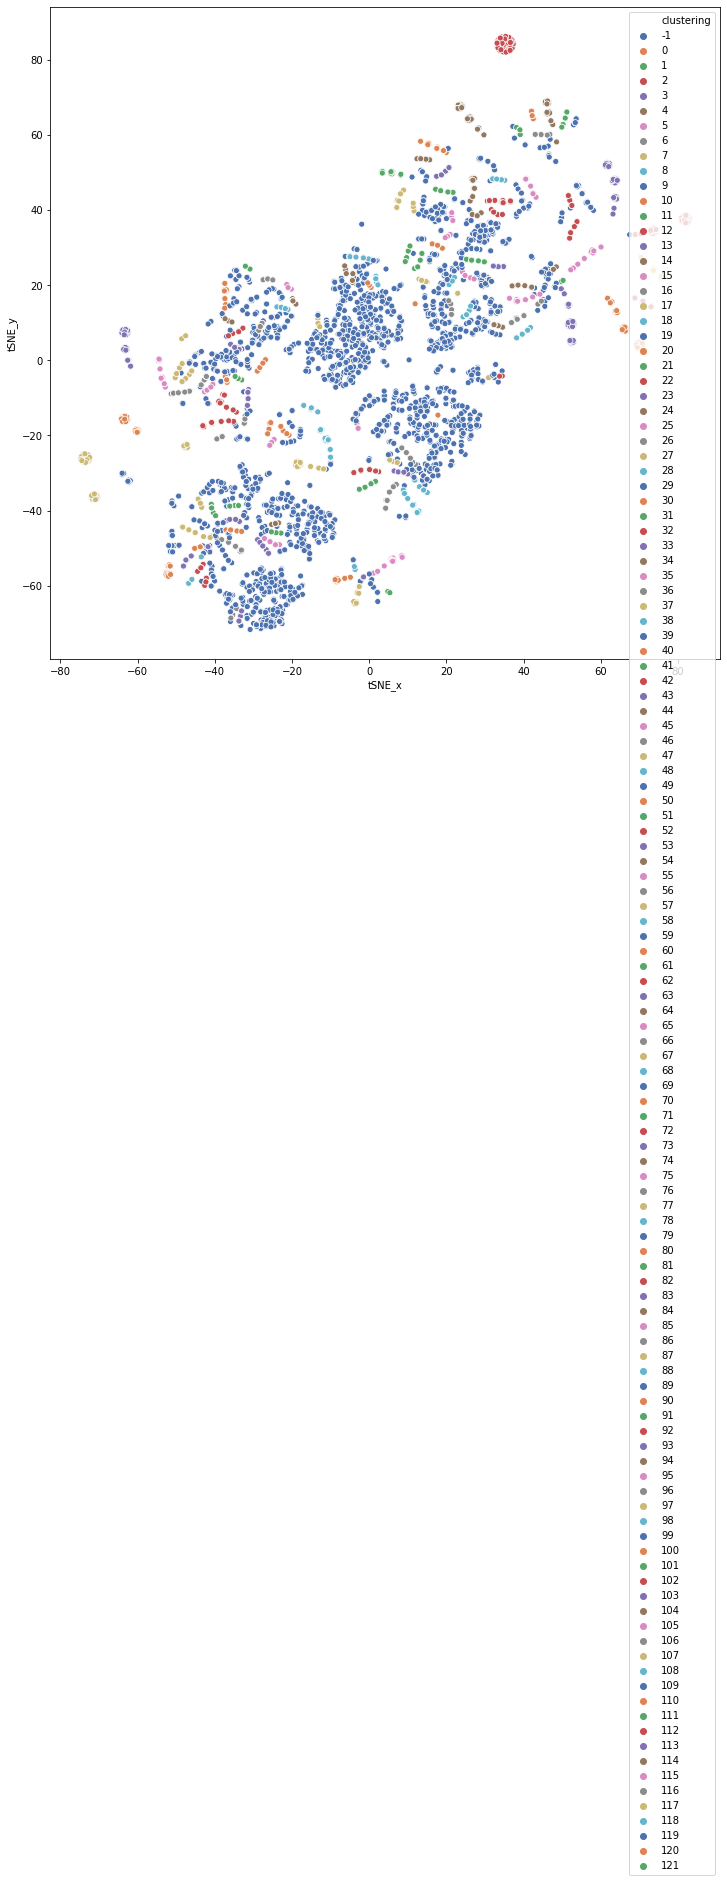

In [19]:
cls_3  = DBSCAN(eps = 0.1, min_samples = 10).fit_predict(ml_scale) 

cluster_vis(cls_3)

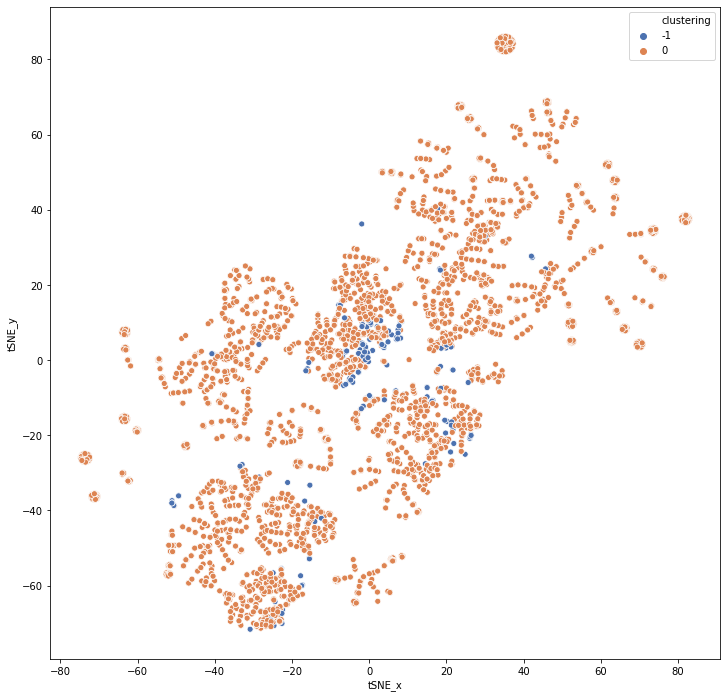

In [20]:
cls_4 = DBSCAN(eps = 0.2, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_4)

From too many to not enough.

In [21]:
#set up silhouette score
from sklearn.metrics import silhouette_score

print(f'silhouette score w noise{silhouette_score(ml_scale, cls_4)}')



silhouette score w noise0.39843522956289606


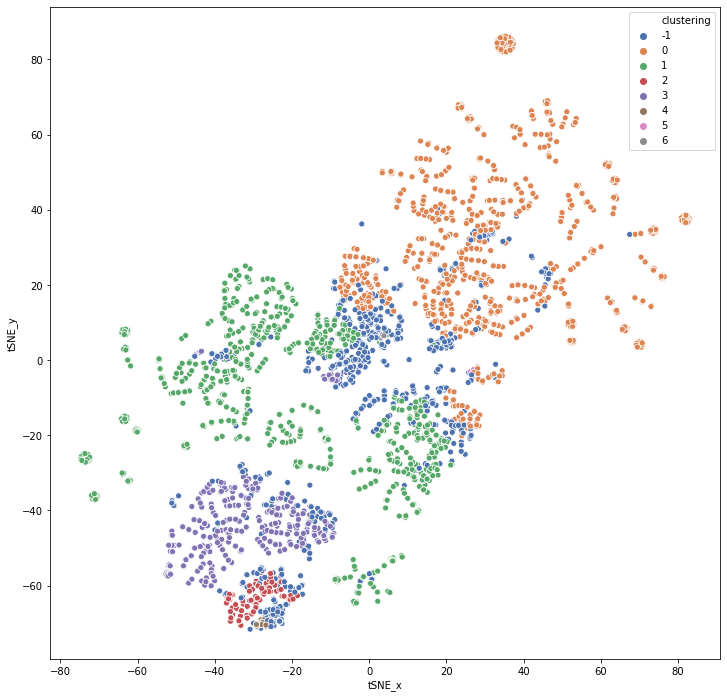

In [22]:
cls_5 = DBSCAN(eps = 0.15, min_samples = 8).fit_predict(ml_scale)

cluster_vis(cls_5)

This is potentially more interesting

In [23]:
print(f'silhouette score w noise{silhouette_score(ml_scale, cls_5)}')

silhouette score w noise0.012636922385054369


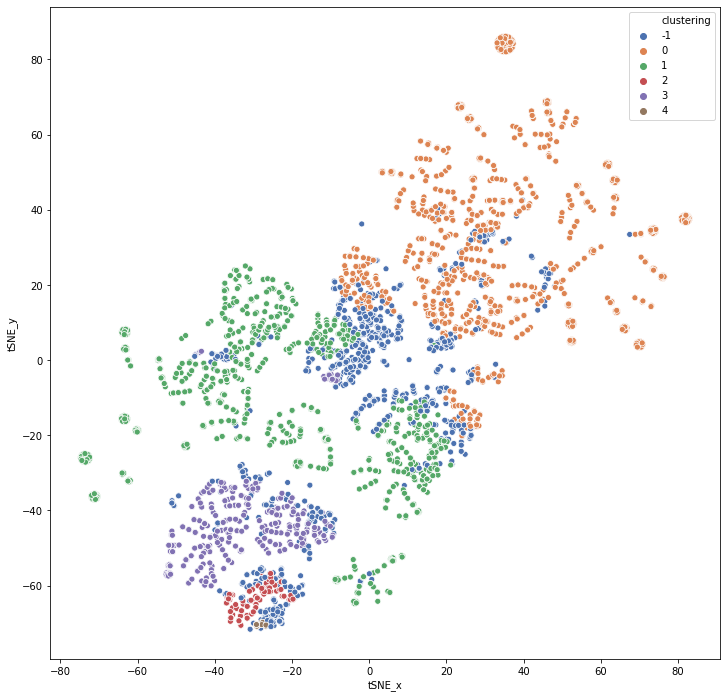

In [24]:
cls_6 = DBSCAN(eps = 0.15, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_6)

In [25]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_6)}')

silhouette score w noise 0.051456436408109194


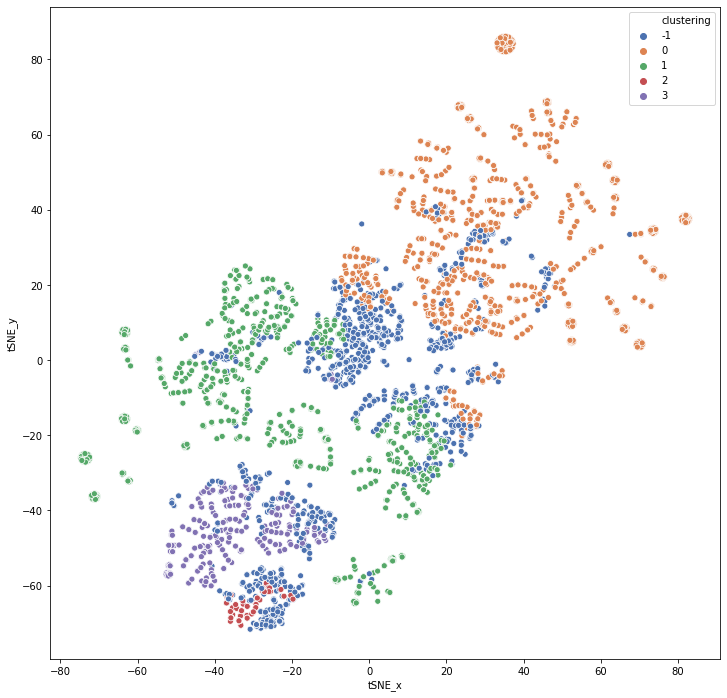

In [26]:
cls_7 = DBSCAN(eps = 0.15, min_samples = 15).fit_predict(ml_scale)

cluster_vis(cls_7)

In [27]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_7)}')

silhouette score w noise 0.037872461201824734


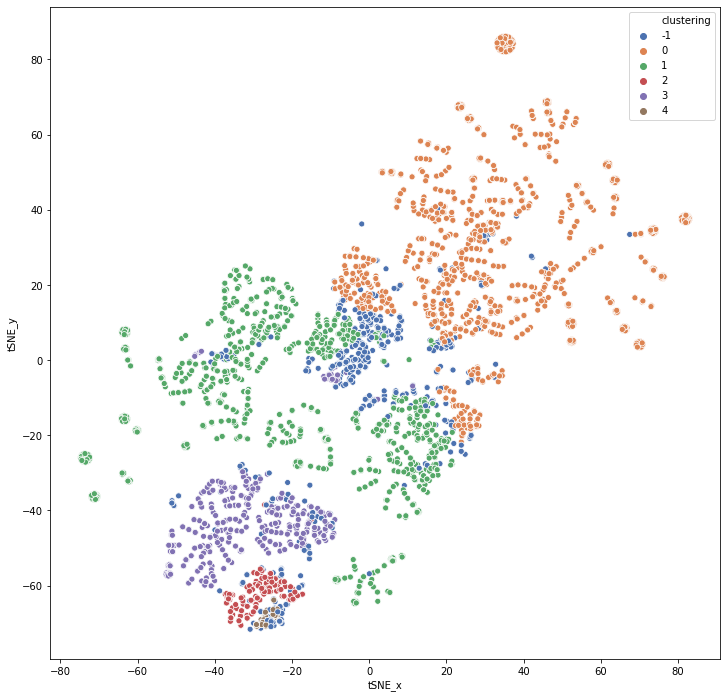

In [28]:
cls_8 = DBSCAN(eps = 0.16, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_8)

In [29]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_7)}')

silhouette score w noise 0.037872461201824734


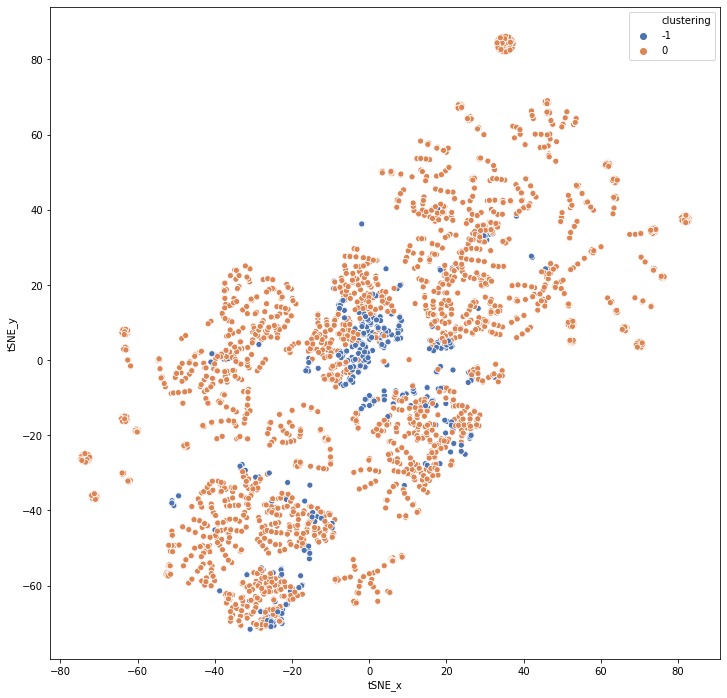

In [30]:
cls_9 = DBSCAN(eps = 0.17, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_9)

In [31]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_9)}')

silhouette score w noise 0.34967141215994824


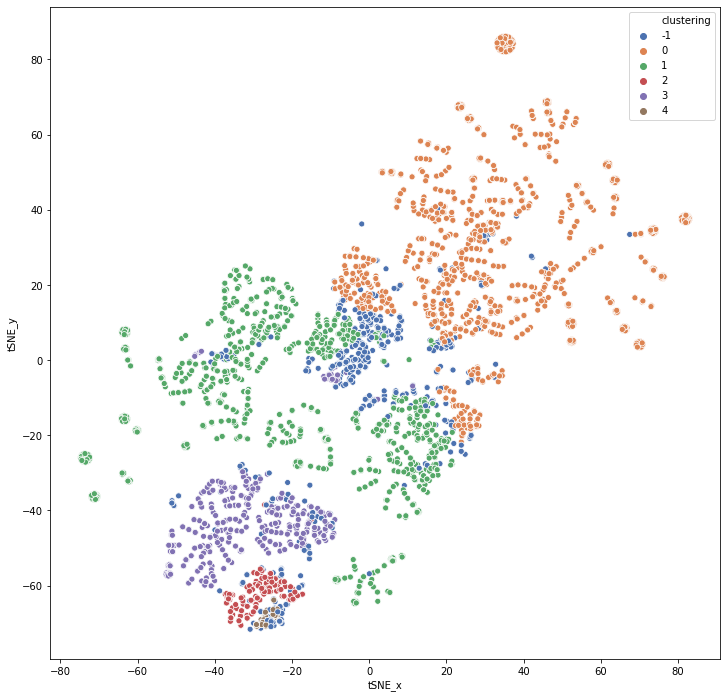

In [32]:
cls_10 = DBSCAN(eps = 0.165, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_10)

In [33]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_10)}')

silhouette score w noise 0.06677221301128296


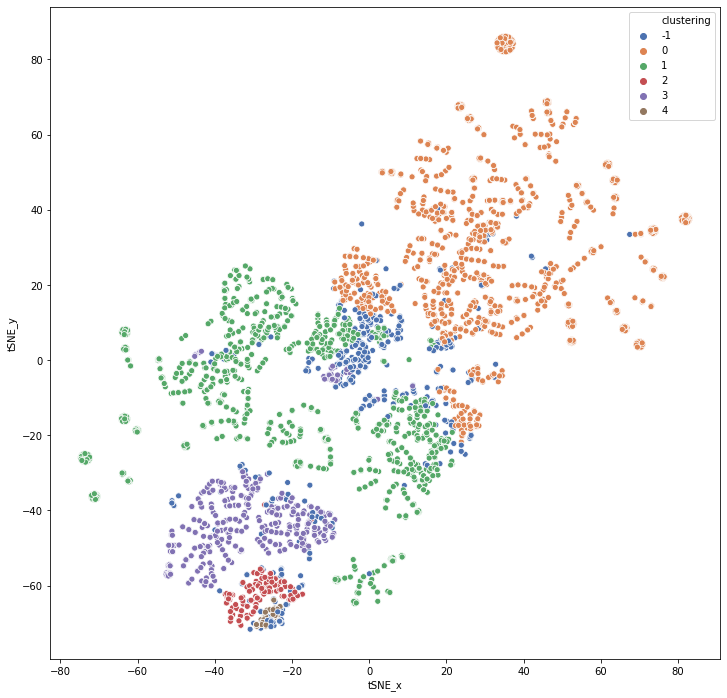

In [34]:
cls_11 = DBSCAN(eps = 0.165, min_samples = 8).fit_predict(ml_scale)

cluster_vis(cls_11)

In [35]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_11)}')

silhouette score w noise 0.06880642907461353


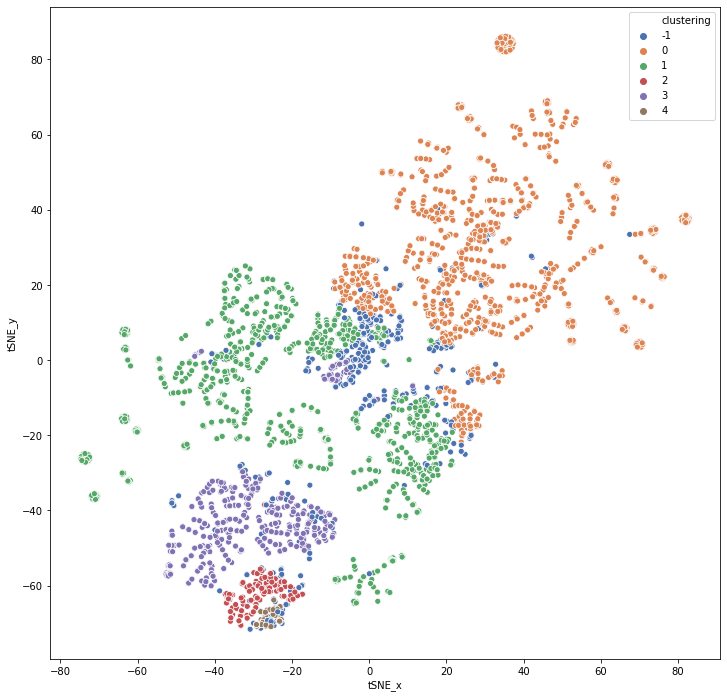

In [36]:
cls_12 = DBSCAN(eps = 0.165, min_samples = 7).fit_predict(ml_scale)

cluster_vis(cls_12)

In [37]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_12)}')

silhouette score w noise 0.07053334275824093


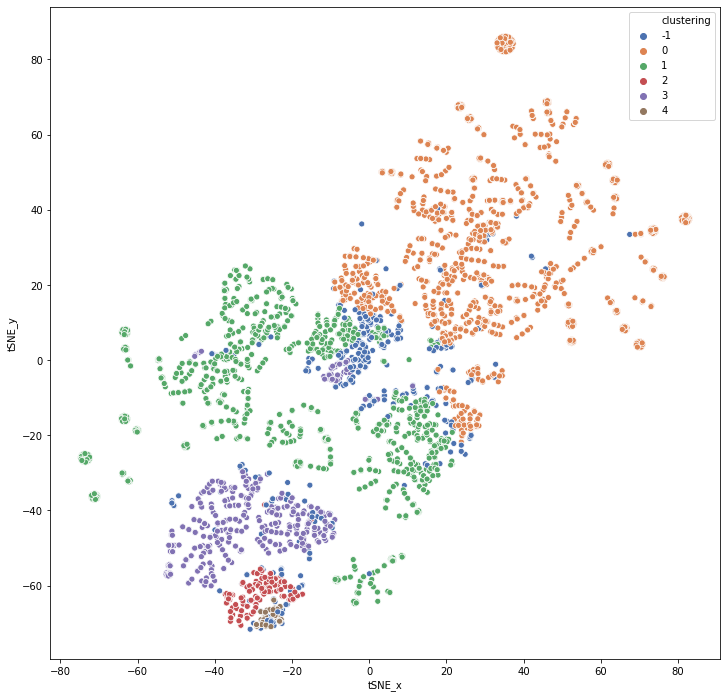

In [38]:
cls_13 = DBSCAN(eps = 0.165, min_samples = 6).fit_predict(ml_scale)

cluster_vis(cls_13)

In [39]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_13)}')

silhouette score w noise 0.07070727786258289


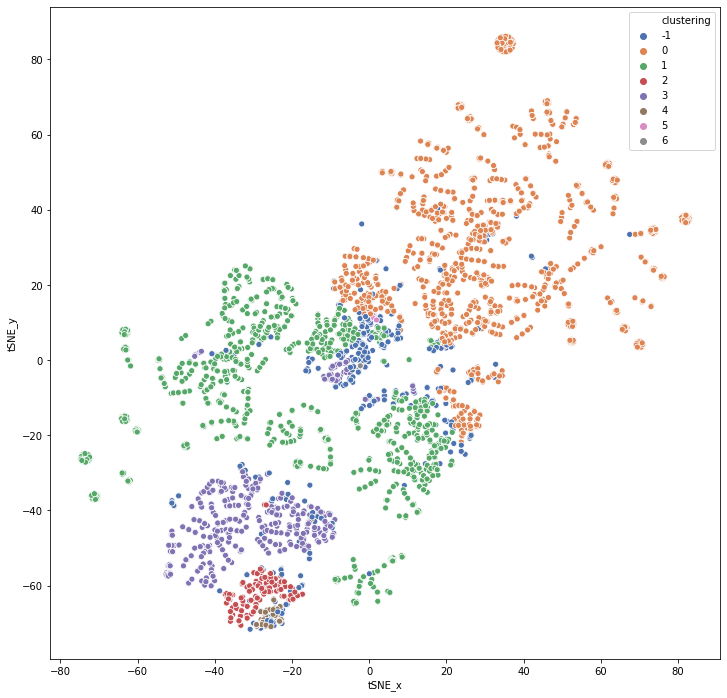

In [40]:
cls_14 = DBSCAN(eps = 0.165, min_samples = 5).fit_predict(ml_scale)

cluster_vis(cls_14)

In [41]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_14)}')

silhouette score w noise 0.04672172361076955


In [42]:
#I am going to try to extract some meaning from cls_16

ml_df_full['clustering'] = cls_13

ml_df_full.head()

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
0           0             2           1            2            0   
1           1             2           0            0            1   
2           2             1           2            1            1   
3           3             1           0            0            3   
4           4             2           0            0            3   

   maillard_words  smoke_words  clustering  
0               0            0           0  
1               2            0           1  
2               1            0           1  
3               0            0           2  
4               1            0           2

In [43]:
cluster_medians = ml_df_full.groupby('clustering').median()

cluster_medians

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
clustering                                                                   
-1              2798.0           2.0         1.0          2.0          2.0   
 0              3207.0           1.0         1.0          1.0          0.0   
 1              2863.0           1.0         1.0          1.0          1.0   
 2              2401.0           1.0         1.0          1.0          3.0   
 3              2640.0           1.0         1.0          1.0          2.0   
 4              2597.5           1.0         1.0          1.0          4.0   

            maillard_words  smoke_words  
clustering                               
-1                     1.0          1.0  
 0                     1.0          0.0  
 1                     1.0          0.0  
 2                     0.0          0.0  
 3                     1.0          0.0  
 4                     0.0          0.0

Most of the categories have one fruity wood and spicy word on average. The main differences seem to come out of the sweet words and maillard words. Smoke seems to doom the whiskey to the noise category. 

In [44]:
cluster_means = ml_df_full.groupby('clustering').mean()

cluster_means

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
clustering                                                                    
-1          2661.134409      2.072581    1.830645     1.938172     1.645161   
 0          3095.155807      1.263456    1.074464     1.182922     0.000000   
 1          2909.648714      1.231926    1.138282     1.219796     1.000000   
 2          2570.589189      1.318919    1.151351     0.940541     3.000000   
 3          2832.642202      1.298820    1.162516     1.129751     2.000000   
 4          2715.145833      1.166667    0.979167     0.937500     4.000000   

            maillard_words  smoke_words  
clustering                               
-1                2.059140     1.591398  
 0                1.048159     0.303116  
 1                1.019893     0.297914  
 2                0.594595     0.037838  
 3                0.884666     0.214941  
 4                0.645833     0.020833

In [45]:
cluster_counts = ml_df_full.groupby('clustering').count()

cluster_counts

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
clustering                                                                   
-1                 372           372         372          372          372   
 0                2471          2471        2471         2471         2471   
 1                2061          2061        2061         2061         2061   
 2                 185           185         185          185          185   
 3                 763           763         763          763          763   
 4                  48            48          48           48           48   

            maillard_words  smoke_words  
clustering                               
-1                     372          372  
 0                    2471         2471  
 1                    2061         2061  
 2                     185          185  
 3                     763          763  
 4                      48           48

In [46]:
#bring in names

ds_query2 = ''' SELECT whiskey_stats.name
                FROM whiskey_stats
                '''

names = pd.read_sql(ds_query2, connct)

names.head()

name
0  Spirit Hound Single Barrel Straight Malt (Barr...
1                     Dogfish Head Straight Malt 40%
2      Balcones Texas Bock Straight Malt Whiskey 50%
3       Woodford Reserve Straight Malt Whiskey 45.2%
4  Spirit Hound Colorado Honey Malt (Barrel No. 4...

In [47]:
ml_df_full['names'] = names['name']

ml_df_full.head()

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
0           0             2           1            2            0   
1           1             2           0            0            1   
2           2             1           2            1            1   
3           3             1           0            0            3   
4           4             2           0            0            3   

   maillard_words  smoke_words  clustering  \
0               0            0           0   
1               2            0           1   
2               1            0           1   
3               0            0           2   
4               1            0           2   

                                               names  
0  Spirit Hound Single Barrel Straight Malt (Barr...  
1                     Dogfish Head Straight Malt 40%  
2      Balcones Texas Bock Straight Malt Whiskey 50%  
3       Woodford Reserve Straight Malt Whiskey 45.2%  
4  Spirit Hound Colorado Honey Malt (Barrel No. 4...

In [48]:
c4 = ml_df_full[ml_df_full['clustering'] == 4]

c4.head()

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
60           60             1           2            1            4   
99           99             2           2            2            4   
163         163             0           0            0            4   
337         337             3           1            3            4   
360         360             2           1            0            4   

     maillard_words  smoke_words  clustering  \
60                2            0           4   
99                0            0           4   
163               0            0           4   
337               1            0           4   
360               0            0           4   

                                                 names  
60   Michter's US*1 Small Batch Unblended American ...  
99                               Nant Bourbon Cask 43%  
163                              Black Eagle Honey 35%  
337           Usquaebach An Ard Ri Cask Strength 57.1%  
360                 Timorous Beastie 18 year old 46.8%

In [49]:
c3 = ml_df_full[ml_df_full['clustering'] == 3]

c3.head()

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
11          11             2           2            4            2   
13          13             1           0            0            2   
16          16             0           2            0            2   
18          18             3           1            0            2   
28          28             0           2            1            2   

    maillard_words  smoke_words  clustering  \
11               2            0           3   
13               3            0           3   
16               2            0           3   
18               2            0           3   
28               0            0           3   

                                                names  
11  Barrell Private Release Malmsey Madeira Cask-F...  
13  Jacob’s Pardon 15 year old Single Barrel Ameri...  
16  Jacob's Pardon 15 year old Single Barrel Ameri...  
18  Barrell Private Release Calvados Cask-Finished...  
28     Hooten Young 12 year old Whiskey (Batch 1) 46%

In [50]:
c2 = ml_df_full[ml_df_full['clustering'] == 2]

c2.head()

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
3            3             1           0            0            3   
4            4             2           0            0            3   
5            5             1           0            0            3   
7            7             2           0            1            3   
17          17             1           3            0            3   

    maillard_words  smoke_words  clustering  \
3                0            0           2   
4                1            0           2   
5                0            0           2   
7                0            0           2   
17               1            0           2   

                                                names  
3        Woodford Reserve Straight Malt Whiskey 45.2%  
4   Spirit Hound Colorado Honey Malt (Barrel No. 4...  
5   Parker’s Heritage Collection Kentucky Straight...  
7   Woodford Reserve Master’s Collection Classic M...  
17  Proof and Wood 25 year old 100 Seasons America...

In [51]:
c1 = ml_df_full[ml_df_full['clustering'] == 1]

c1.head()

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
1            1             2           0            0            1   
2            2             1           2            1            1   
6            6             0           4            1            1   
9            9             0           2            1            1   
19          19             3           0            3            1   

    maillard_words  smoke_words  clustering  \
1                2            0           1   
2                1            0           1   
6                1            0           1   
9                1            0           1   
19               1            0           1   

                                                names  
1                      Dogfish Head Straight Malt 40%  
2       Balcones Texas Bock Straight Malt Whiskey 50%  
6   Woodford Reserve Master’s Collection Straight ...  
9   Barrell Private Release Tokaji Cask-Finished K...  
19  Barrell Private Release Sicilian Amaro Cask-Fi...

In [52]:
c0 = ml_df_full[ml_df_full['clustering'] == 0]

c0.head()

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
0            0             2           1            2            0   
10          10             5           1            1            0   
12          12             3           2            5            0   
14          14             4           2            0            0   
15          15             2           2            1            0   

    maillard_words  smoke_words  clustering  \
0                0            0           0   
10               3            0           0   
12               1            0           0   
14               1            0           0   
15               1            0           0   

                                                names  
0   Spirit Hound Single Barrel Straight Malt (Barr...  
10  Barrell Private Release Ruby Port Cask-Finishe...  
12  Barrell 25 year old Cask-Strength American Whi...  
14  Barrell Private Release Hermann J. Wiemer Nobl...  
15  Barrell Private Release St. Agrestis Brooklyn ...

The algorythm very clearly picked up on differences in sweetness exclusively on this clustering attempt. This is going to be something worth looking into. I think it's time to reengineer the features again though, to expand the feature words further, and to normalize categories to the number of words used in the review. 

In [53]:
connct.close()

Second thought: It might not be surprising that the algorythm found a simple pattern based on sweet words with no other nuance based on the range of the clusters. There is clearly finer structure to the clusters in the tSNE, so maybe I should constrain epsilon to lower values and look at a larger number of clusters. If I want small groups of very similar whiskies, this is clearly how I would tell that and it seems like large groups are most likely to rely on the presence of a unique word, or a common feature. 

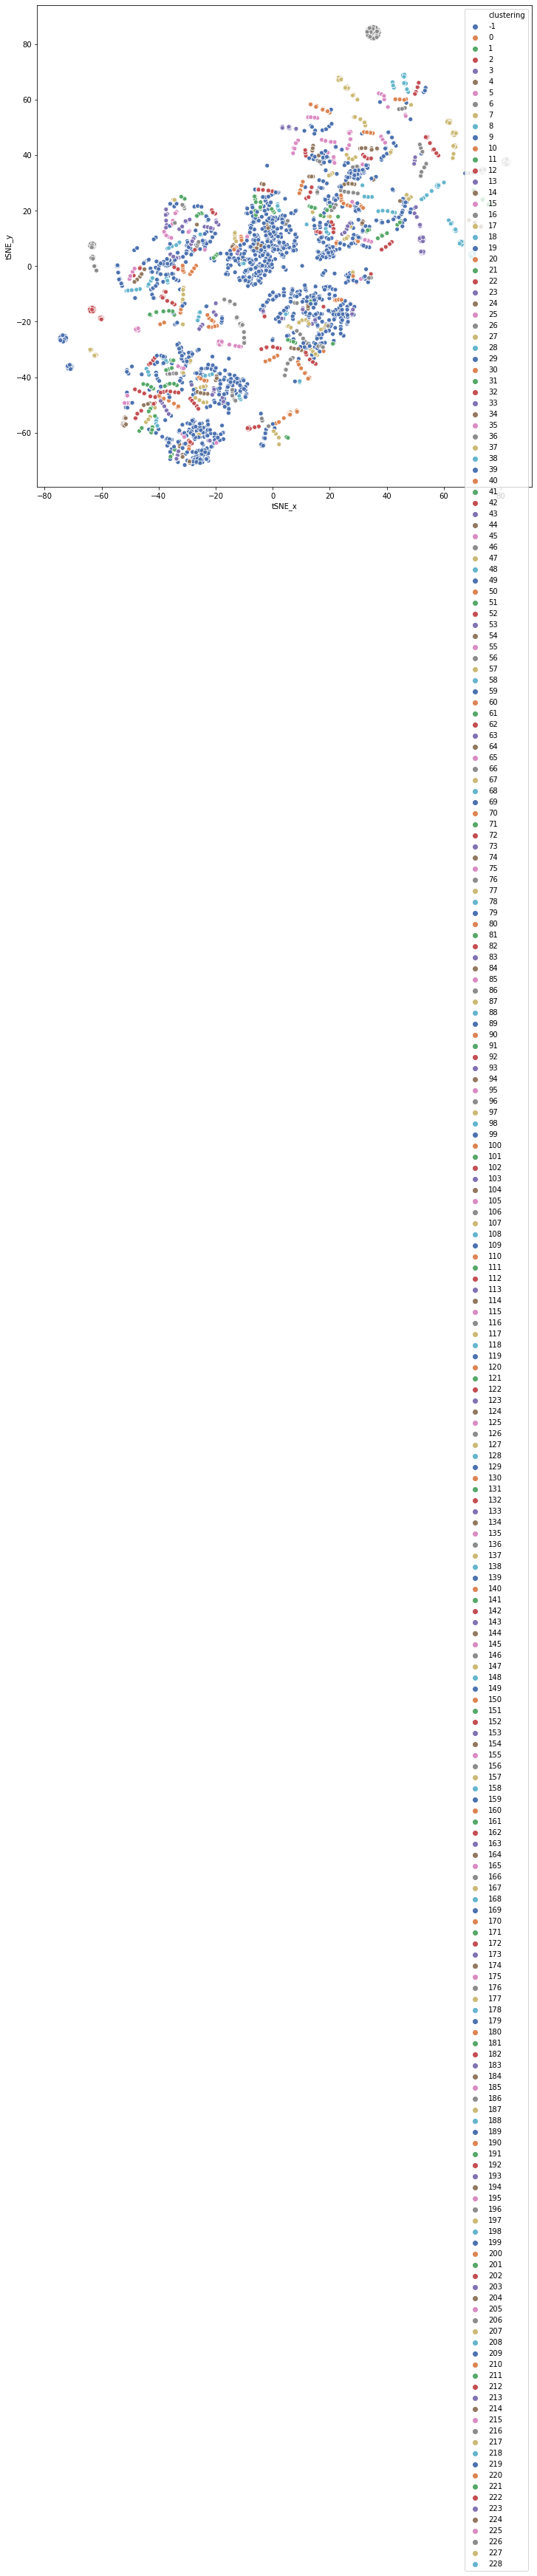

In [54]:
cls_15 = DBSCAN(eps = 0.11, min_samples = 5).fit_predict(ml_scale)

cluster_vis(cls_15)

In [55]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_15)}')

silhouette score w noise 0.11442959462689595


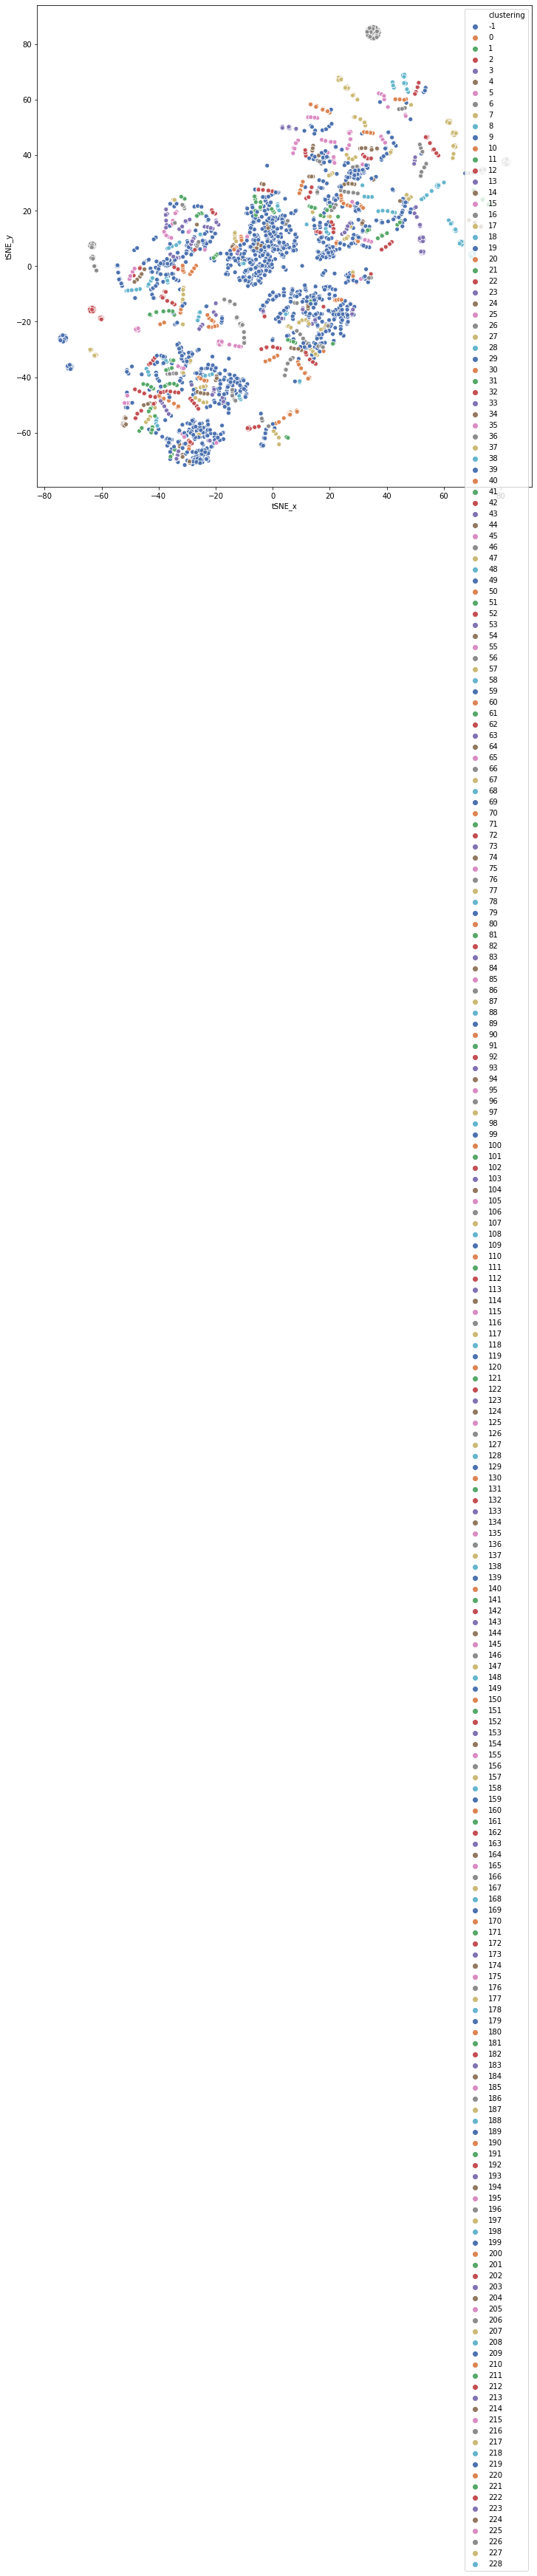

In [56]:
cls_16 = DBSCAN(eps = 0.12, min_samples = 5).fit_predict(ml_scale)

cluster_vis(cls_16)

In [57]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_16)}')

silhouette score w noise 0.11442959462689595


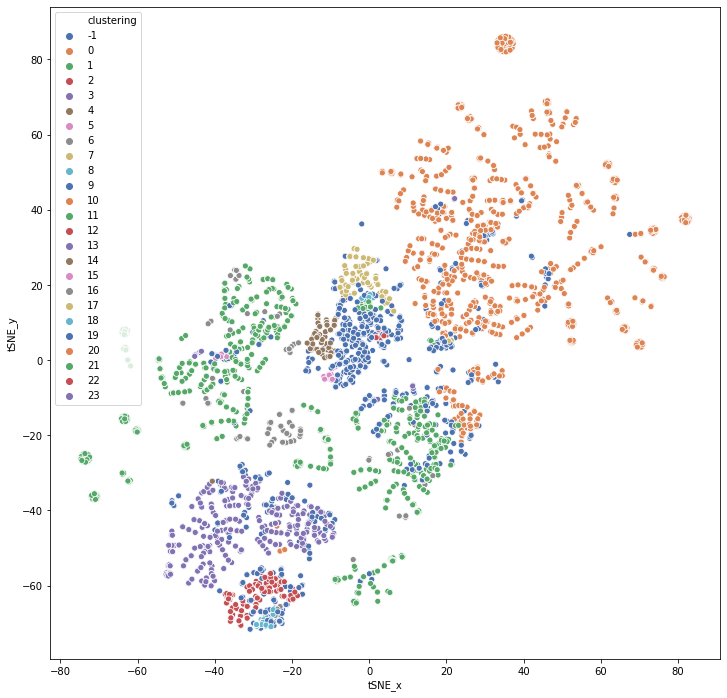

In [58]:
cls_17 = DBSCAN(eps = 0.13, min_samples = 5).fit_predict(ml_scale)

cluster_vis(cls_17)

In [59]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_17)}')

silhouette score w noise -0.12698357675069574


# Exploring a highly segmented clustering model

In [60]:
ml_df_hs = ml_df_full

ml_df_hs['clustering'] = cls_16

hs_meds = ml_df_hs.groupby('clustering').median()

hs_meds.head(50)

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
clustering                                                                   
-1              2940.0           1.0         1.0          2.0          1.0   
 0              2694.0           1.0         1.0          2.0          0.0   
 1              3385.0           1.0         0.0          0.0          1.0   
 2              1981.0           1.0         2.0          1.0          1.0   
 3              2368.0           1.0         0.0          0.0          3.0   
 4              3504.0           1.0         2.0          0.0          0.0   
 5              1632.0           1.0         2.0          1.0          0.0   
 6              2062.0           1.0         1.0          0.0          2.0   
 7              1930.0           2.0         0.0          3.0          1.0   
 8              2889.0           1.0         0.0          1.0          0.0   
 9              2946.0           1.0         0.0          1.0          1.0   
 10             1109.0           1.0         1.0          1.0          0.0   
 11             2665.0           1.0         0.0          1.0          1.0   
 12             1761.5           1.5         2.0          1.0          2.0   
 13             1344.0           2.0         1.0          4.0          1.0   
 14             3337.0           1.0         3.0          0.0          1.0   
 15             3450.0           2.0         2.0          1.0          2.0   
 16             2640.0           1.0         1.0          1.0          1.0   
 17             2884.0           1.0         0.0          0.0          1.0   
 18             3663.0           1.0         1.0          0.0          0.0   
 19             2342.0           1.0         3.0          2.0          1.0   
 20             2456.0           2.0         2.0          1.0          0.0   
 21             2901.0           2.0         3.0          1.0          2.0   
 22             2632.0           1.0         3.0          0.0          0.0   
 23             3146.0           1.0         1.0          1.0          0.0   
 24               57.0           1.0         4.0          0.0          1.0   
 25             1569.0           1.5         2.0          0.0          1.0   
 26             2977.5           2.0         1.0          3.0          1.0   
 27             2673.0           1.0         1.0          2.0          2.0   
 28             4172.0           1.5         2.0          0.0          1.0   
 29             3412.0           1.0         0.0          0.0          1.0   
 30             2346.5           1.0         0.0          2.0          1.0   
 31             1914.0           2.0         1.0          0.0          2.0   
 32             2983.0           1.0         0.0          1.0          1.0   
 33             3151.0           1.0         1.0          2.0          0.0   
 34             3283.0           1.0         1.0          0.0          0.0   
 35             2052.0           1.0         3.0          0.0          1.0   
 36             2646.5           1.0         1.0          0.0          1.0   
 37             2711.5           1.0         1.0          1.0          0.0   
 38             4687.0           0.0         0.0          0.0          1.0   
 39             2512.0           1.0         2.0          0.0          1.0   
 40             2255.5           1.0         1.0          1.0          2.0   
 41             4059.5           1.0         0.0          0.0          0.0   
 42             3906.0           1.0         0.0          0.0          0.0   
 43             2207.0           1.0         1.0          1.0          2.0   
 44             2280.0           0.0         0.0          0.0          2.0   
 45             2029.0           1.0         2.0          2.0          0.0   
 46             3798.0           1.0         0.0          0.0          0.0   
 47             2812.0           1.0         0.0          1.0          0.0   
 48             2667.0           1

In [61]:
hs_ct = ml_df_hs.groupby('clustering').count()

hs_ct.head(25)

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
clustering                                                                   
-1                1551          1551        1551         1551         1551   
 0                  43            43          43           43           43   
 1                  23            23          23           23           23   
 2                  45            45          45           45           45   
 3                  23            23          23           23           23   
 4                  42            42          42           42           42   
 5                  44            44          44           44           44   
 6                  13            13          13           13           13   
 7                   9             9           9            9            9   
 8                  56            56          56           56           56   
 9                  17            17          17           17           17   
 10                  7             7           7            7            7   
 11                  9             9           9            9            9   
 12                 18            18          18           18           18   
 13                 10            10          10           10           10   
 14                 17            17          17           17           17   
 15                  7             7           7            7            7   
 16                 56            56          56           56           56   
 17                 51            51          51           51           51   
 18                103           103         103          103          103   
 19                 13            13          13           13           13   
 20                 16            16          16           16           16   
 21                  5             5           5            5            5   
 22                 14            14          14           14           14   
 23                 88            88          88           88           88   

            maillard_words  smoke_words  names  
clustering                                      
-1                    1551         1551   1551  
 0                      43           43     43  
 1                      23           23     23  
 2                      45           45     45  
 3                      23           23     23  
 4                      42           42     42  
 5                      44           44     44  
 6                      13           13     13  
 7                       9            9      9  
 8                      56           56     56  
 9                      17           17     17  
 10                      7            7      7  
 11                      9            9      9  
 12                     18           18     18  
 13                     10           10     10  
 14                     17           17     17  
 15                      7            7      7  
 16                     56           56     56  
 17                     51           51     51  
 18                    103          103    103  
 19                     13           13     13  
 20                     16           16     16  
 21                      5            5      5  
 22                     14           14     14  
 23                     88           88     88

In [62]:
hs_mn = ml_df_hs.groupby('clustering').mean()

hs_mn.head(50)

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
clustering                                                                    
-1          2812.907157      1.607350     1.68343     1.807866     1.239845   
 0          2979.627907      1.441860     1.00000     2.000000     0.000000   
 1          3373.260870      1.000000     0.00000     0.000000     1.000000   
 2          2503.777778      1.177778     2.00000     1.000000     1.000000   
 3          2804.739130      0.913043     0.00000     0.000000     3.000000   
 4          3257.452381      1.238095     2.00000     0.000000     0.000000   
 5          2324.750000      0.954545     2.00000     1.000000     0.000000   
 6          2570.846154      1.615385     1.00000     0.000000     2.000000   
 7          2537.333333      2.000000     0.00000     3.000000     1.000000   
 8          2861.875000      1.660714     0.00000     1.000000     0.000000   
 9          2796.705882      1.117647     0.00000     1.000000     1.000000   
 10         1859.285714      1.000000     1.00000     1.000000     0.000000   
 11         2305.444444      1.222222     0.00000     1.000000     1.000000   
 12         2696.000000      1.666667     2.00000     1.000000     2.000000   
 13         1672.800000      2.000000     1.00000     4.000000     1.000000   
 14         3030.647059      1.117647     3.00000     0.000000     1.000000   
 15         2890.857143      2.428571     2.00000     1.000000     2.000000   
 16         2897.964286      1.267857     1.00000     1.000000     1.000000   
 17         3004.156863      1.313725     0.00000     0.000000     1.000000   
 18         3467.223301      1.184466     1.00000     0.000000     0.000000   
 19         2431.384615      1.000000     3.00000     2.000000     1.000000   
 20         2822.562500      1.812500     2.00000     1.000000     0.000000   
 21         2760.800000      1.800000     3.00000     1.000000     2.000000   
 22         2695.642857      1.142857     3.00000     0.000000     0.000000   
 23         2958.306818      1.215909     1.00000     1.000000     0.000000   
 24         1301.400000      0.600000     4.00000     0.000000     1.000000   
 25         2073.500000      1.583333     2.00000     0.000000     1.000000   
 26         2733.318182      1.500000     1.00000     3.000000     1.000000   
 27         2535.222222      1.333333     1.00000     2.000000     2.000000   
 28         3751.300000      1.700000     2.00000     0.000000     1.000000   
 29         3402.024000      1.072000     0.00000     0.000000     1.000000   
 30         2894.450000      1.000000     0.00000     2.000000     1.000000   
 31         2153.523810      1.380952     1.00000     0.000000     2.000000   
 32         3278.218391      1.011494     0.00000     1.000000     1.000000   
 33         2858.040816      1.204082     1.00000     2.000000     0.000000   
 34         3288.714286      0.857143     1.00000     0.000000     0.000000   
 35         2743.904762      1.333333     3.00000     0.000000     1.000000   
 36         2937.038462      0.948718     1.00000     0.000000     1.000000   
 37         3166.397727      1.443182     1.00000     1.000000     0.000000   
 38         3815.521739      0.521739     0.00000     0.000000     1.000000   
 39         2779.888889      1.222222     2.00000     0.000000     1.000000   
 40         2353.050000      1.425000     1.00000     1.000000     2.000000   
 41         3609.166667      0.962963     0.00000     0.000000     0.000000   
 42         3411.851852      0.925926     0.00000     0.000000     0.000000   
 43         2343.086957      1.260870     1.00000     1.000000     2.000000   
 44         2891.857143      0.795918     0.00000     0.000000     2.000000   
 45         2332.782609      1.565217     2.00000     2.000000     0.000000   
 46         3468.770950      0.899441     0.00000     0.000000     0.000000   
 47         3018.415730      1.191011     0.00000     1.000000 

In [63]:
#look at cluser 38 out of interest

c38 = ml_df_hs[ml_df_hs['clustering'] == 38]

c38

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
83            83             2           0            0            1   
375          375             0           0            0            1   
440          440             1           0            0            1   
2034        2034             0           0            0            1   
2120        2120             0           0            0            1   
2283        2283             1           0            0            1   
2777        2777             0           0            0            1   
3455        3455             0           0            0            1   
4165        4165             0           0            0            1   
4225        4225             0           0            0            1   
4580        4580             0           0            0            1   
4687        4687             0           0            0            1   
4798        4798             1           0            0            1   
4831        4831             0           0            0            1   
4951        4951             2           0            0            1   
4982        4982             1           0            0            1   
5028        5028             0           0            0            1   
5165        5165             1           0            0            1   
5202        5202             1           0            0            1   
5294        5294             2           0            0            1   
5340        5340             0           0            0            1   
5417        5417             0           0            0            1   
5525        5525             0           0            0            1   

      maillard_words  smoke_words  clustering  \
83                 0            1          38   
375                0            1          38   
440                0            1          38   
2034               0            1          38   
2120               0            1          38   
2283               0            1          38   
2777               0            1          38   
3455               0            1          38   
4165               0            1          38   
4225               0            1          38   
4580               0            1          38   
4687               0            1          38   
4798               0            1          38   
4831               0            1          38   
4951               0            1          38   
4982               0            1          38   
5028               0            1          38   
5165               0            1          38   
5202               0            1          38   
5294               0            1          38   
5340               0            1          38   
5417               0            1          38   
5525               0            1          38   

                                                  names  
83                      Heartwood Vat Out of Hell 67.4%  
375                                Clan Denny Islay 46%  
440                              Timorous Beastie 46.8%  
2034                       Sea Fog American Whiskey 45%  
2120                   Rieger’s Kansas City Whiskey 46%  
2283                            Palmetto Whiskey 44.65%  
2777                 Meiyo 17 year old Single Grain 42%  
3455                        St. George’s Chapter 13 49%  
4165                  The Macallan Easter Elchies 52.3%  
4225  Lp4 Elements of Islay (distilled at Laphroaig)...  
4580  The MacPhail’s Collection 8 year old (distille...  
4687                         Glenfiddich Project XX 47%  
4798         Caol Ila 2002 Feis Ile 2014 bottling 55.5%  
4831  Wemyss Malts Lemon Zest 1998 (distilled at Auc...  
4951  Douglas Laing Old Particular (distilled at Bla...  
4982                            Tomatin 15 year old 52%  
5028                        Glen Scotia 12 year old 46%  
5165  Creative Whisky Co. Exclusive Malts (distilled... 

What the algorythm appears to have done in this case is matched along as many lines as possible. Cluster 38 has full agreement in all features except for the fruity words. Amazingly, this also produced results for the majority of whiskeys in my database. About a quarter of them are still not clustered with this approach. It might be worth dinking around with epsilon and min samples a bit more before I try reengineering features, because I'm getting very close to what I want with this. 

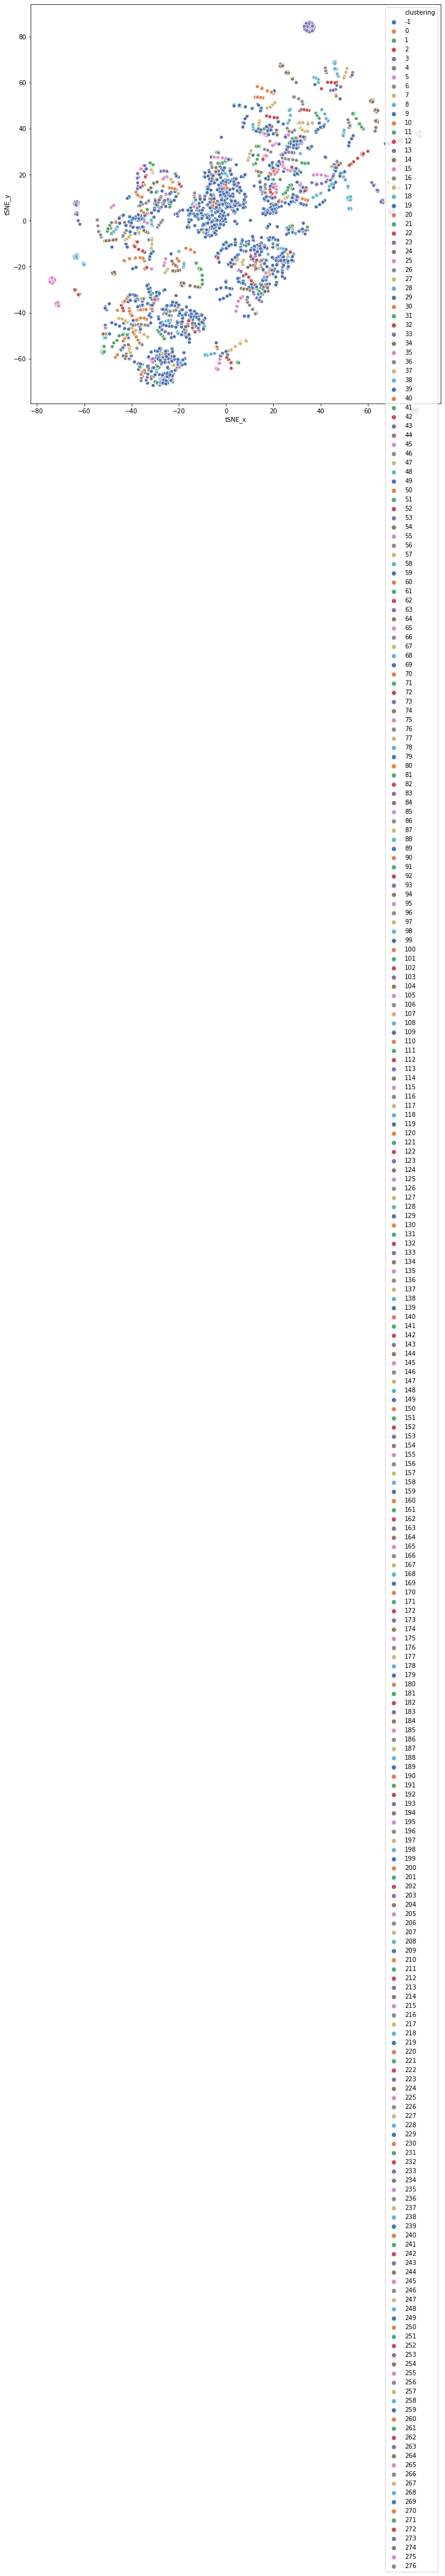

In [64]:
cls_18 = DBSCAN(eps = 0.12, min_samples = 4).fit_predict(ml_scale)

cluster_vis(cls_18)

In [65]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_18)}')

silhouette score w noise 0.1458196764514237


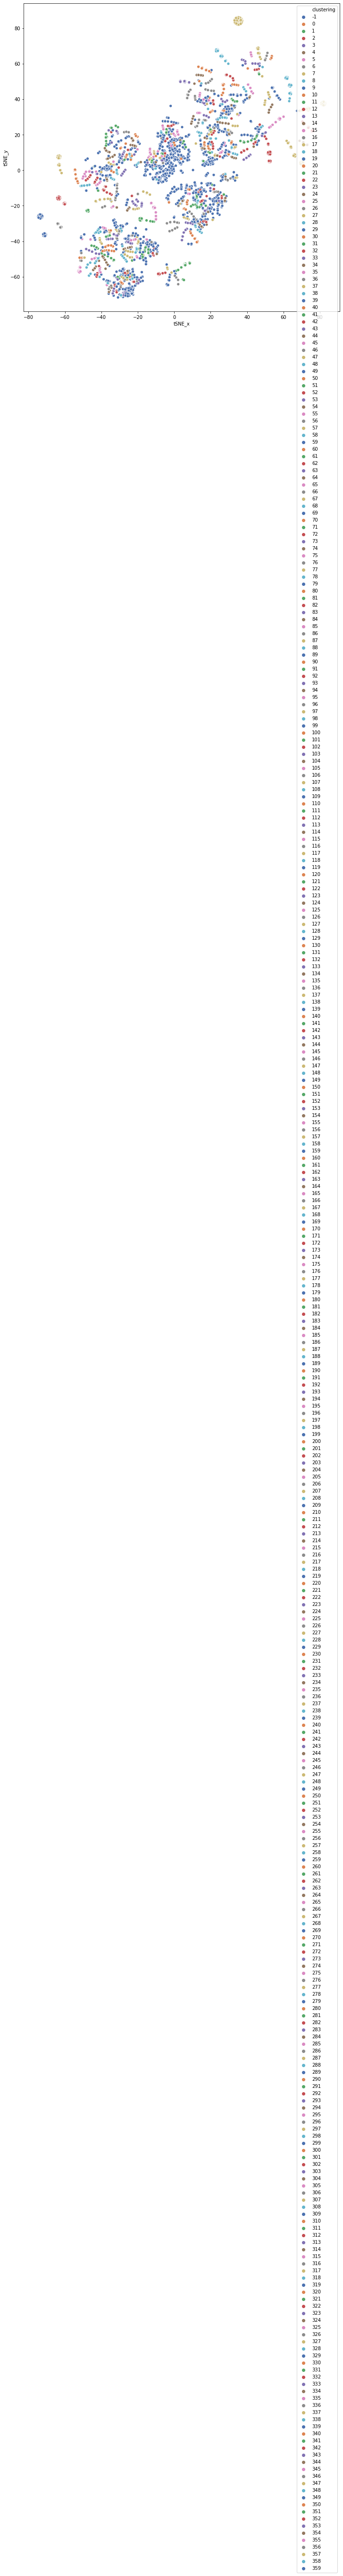

In [66]:
cls_19 = DBSCAN(eps = 0.12, min_samples = 3).fit_predict(ml_scale)

cluster_vis(cls_19)

In [67]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_19)}')

silhouette score w noise 0.18186760456762296


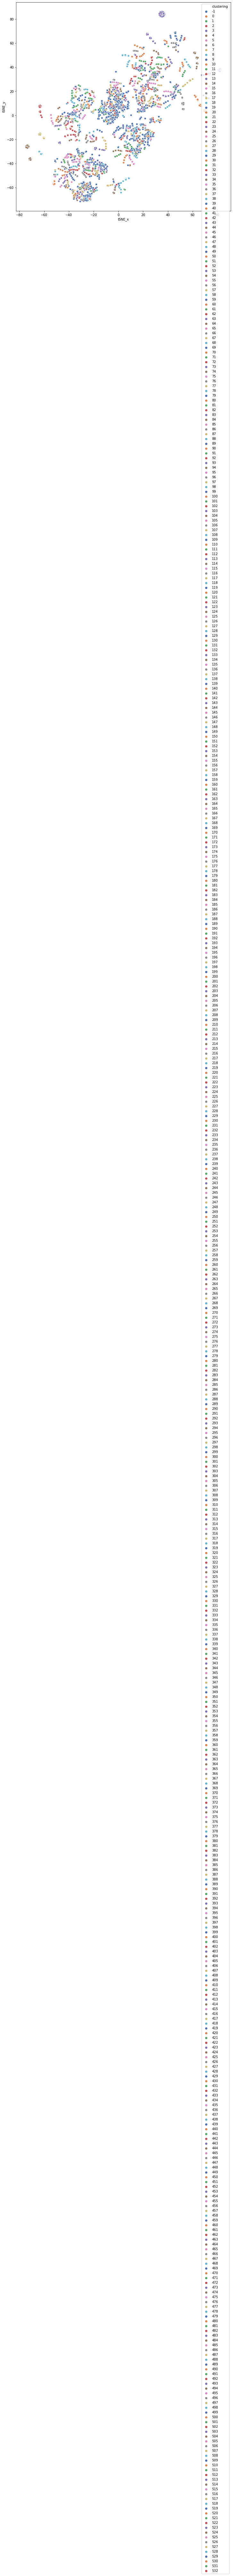

In [68]:
cls_20 = DBSCAN(eps = 0.12, min_samples = 2).fit_predict(ml_scale)

cluster_vis(cls_20)

In [69]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_20)}')

silhouette score w noise 0.2465081138907909


# Inspecting groups at the limit of DBSCAN clustering

In [70]:
ml_df_shs = ml_df_full

ml_df_shs['clustering'] = cls_20

shs_count = ml_df_shs.groupby('clustering').count()

shs_count.head(50)

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
clustering                                                                   
-1                 731           731         731          731          731   
 0                  43            43          43           43           43   
 1                  23            23          23           23           23   
 2                  45            45          45           45           45   
 3                  23            23          23           23           23   
 4                  11            11          11           11           11   
 5                   4             4           4            4            4   
 6                   2             2           2            2            2   
 7                  16            16          16           16           16   
 8                   3             3           3            3            3   
 9                   4             4           4            4            4   
 10                  4             4           4            4            4   
 11                 42            42          42           42           42   
 12                 44            44          44           44           44   
 13                  6             6           6            6            6   
 14                  4             4           4            4            4   
 15                 13            13          13           13           13   
 16                 10            10          10           10           10   
 17                 56            56          56           56           56   
 18                 17            17          17           17           17   
 19                  7             7           7            7            7   
 20                  6             6           6            6            6   
 21                  9             9           9            9            9   
 22                 19            19          19           19           19   
 23                 10            10          10           10           10   
 24                 17            17          17           17           17   
 25                  7             7           7            7            7   
 26                 15            15          15           15           15   
 27                 56            56          56           56           56   
 28                 51            51          51           51           51   
 29                  8             8           8            8            8   
 30                103           103         103          103          103   
 31                 13            13          13           13           13   
 32                 16            16          16           16           16   
 33                  5             5           5            5            5   
 34                 14            14          14           14           14   
 35                  2             2           2            2            2   
 36                 88            88          88           88           88   
 37                  5             5           5            5            5   
 38                 12            12          12           12           12   
 39                  2             2           2            2            2   
 40                  4             4           4            4            4   
 41                 22            22          22           22           22   
 42                 18            18          18           18           18   
 43                 20            20          20           20           20   
 44                125           125         125          125          125   
 45                 40            40          40           40           40   
 46                 21            21          21           21           21   
 47                 87            87          87           87           87   
 48                 49            

In [71]:
shs_mean = ml_df_shs.groupby('clustering').mean()

shs_mean.head(50)

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
clustering                                                                    
-1          2769.365253      1.923393    1.811218      1.93844     1.329685   
 0          2979.627907      1.441860    1.000000      2.00000     0.000000   
 1          3373.260870      1.000000    0.000000      0.00000     1.000000   
 2          2503.777778      1.177778    2.000000      1.00000     1.000000   
 3          2804.739130      0.913043    0.000000      0.00000     3.000000   
 4          3135.272727      0.454545    0.000000      0.00000     3.000000   
 5          1158.750000      0.000000    4.000000      1.00000     1.000000   
 6          1275.500000      2.000000    0.000000      1.00000     3.000000   
 7          3121.812500      1.750000    1.000000      1.00000     0.000000   
 8          2443.333333      1.666667    2.000000      4.00000     2.000000   
 9          1389.750000      2.750000    2.000000      5.00000     0.000000   
 10         3236.750000      0.500000    0.000000      0.00000     2.000000   
 11         3257.452381      1.238095    2.000000      0.00000     0.000000   
 12         2324.750000      0.954545    2.000000      1.00000     0.000000   
 13         2994.333333      0.833333    2.000000      0.00000     2.000000   
 14         2892.000000      1.750000    3.000000      0.00000     3.000000   
 15         2570.846154      1.615385    1.000000      0.00000     2.000000   
 16         2546.800000      2.300000    0.000000      3.00000     1.000000   
 17         2861.875000      1.660714    0.000000      1.00000     0.000000   
 18         2796.705882      1.117647    0.000000      1.00000     1.000000   
 19         1859.285714      1.000000    1.000000      1.00000     0.000000   
 20         1695.833333      1.666667    1.000000      1.00000     1.000000   
 21         2305.444444      1.222222    0.000000      1.00000     1.000000   
 22         2565.052632      1.894737    2.000000      1.00000     2.000000   
 23         1672.800000      2.000000    1.000000      4.00000     1.000000   
 24         3030.647059      1.117647    3.000000      0.00000     1.000000   
 25         2890.857143      2.428571    2.000000      1.00000     2.000000   
 26         3051.333333      1.866667    1.000000      3.00000     0.000000   
 27         2897.964286      1.267857    1.000000      1.00000     1.000000   
 28         3004.156863      1.313725    0.000000      0.00000     1.000000   
 29         1692.625000      1.750000    3.000000      3.00000     0.000000   
 30         3467.223301      1.184466    1.000000      0.00000     0.000000   
 31         2431.384615      1.000000    3.000000      2.00000     1.000000   
 32         2822.562500      1.812500    2.000000      1.00000     0.000000   
 33         2760.800000      1.800000    3.000000      1.00000     2.000000   
 34         2695.642857      1.142857    3.000000      0.00000     0.000000   
 35         1422.000000      0.500000    1.000000      1.00000     5.000000   
 36         2958.306818      1.215909    1.000000      1.00000     0.000000   
 37         1301.400000      0.600000    4.000000      0.00000     1.000000   
 38         2073.500000      1.583333    2.000000      0.00000     1.000000   
 39          812.500000      0.500000    5.000000      0.00000     1.000000   
 40         1691.000000      0.250000    3.000000      0.00000     1.000000   
 41         2733.318182      1.500000    1.000000      3.00000     1.000000   
 42         2535.222222      1.333333    1.000000      2.00000     2.000000   
 43         3751.300000      1.700000    2.000000      0.00000     1.000000   
 44         3402.024000      1.072000    0.000000      0.00000     1.000000   
 45         2894.450000      1.000000    0.000000      2.00000     1.000000   
 46         2153.523810      1.380952    1.000000      0.00000     2.000000   
 47         3278.218391      1.011494    0.000000      1.00000 

In [72]:
c39 = ml_df_shs[ml_df_shs['clustering'] == 39]

c39

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
56            56             0           5            0            1   
1569        1569             1           5            0            1   

      maillard_words  smoke_words  clustering  \
56                 2            0          39   
1569               2            0          39   

                                                  names  
56           Relativity American Whisky (prototype) 40%  
1569  Buffalo Trace Experimental Collection #7 Heavy...

In [73]:
c36 = ml_df_shs[ml_df_shs['clustering'] == 36]

c36.head(30)

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
49            49             0           1            1            0   
70            70             2           1            1            0   
126          126             4           1            1            0   
153          153             2           1            1            0   
177          177             0           1            1            0   
256          256             1           1            1            0   
340          340             1           1            1            0   
349          349             1           1            1            0   
377          377             0           1            1            0   
475          475             1           1            1            0   
507          507             1           1            1            0   
557          557             3           1            1            0   
651          651             1           1            1            0   
847          847             1           1            1            0   
920          920             1           1            1            0   
1019        1019             2           1            1            0   
1021        1021             3           1            1            0   
1096        1096             0           1            1            0   
1153        1153             3           1            1            0   
1213        1213             2           1            1            0   
1241        1241             1           1            1            0   
1417        1417             1           1            1            0   
1527        1527             0           1            1            0   
1535        1535             0           1            1            0   
1591        1591             0           1            1            0   
1623        1623             1           1            1            0   
1628        1628             0           1            1            0   
1657        1657             1           1            1            0   
1685        1685             0           1            1            0   
1814        1814             1           1            1            0   

      maillard_words  smoke_words  clustering  \
49                 1            0          36   
70                 1            0          36   
126                1            0          36   
153                1            0          36   
177                1            0          36   
256                1            0          36   
340                1            0          36   
349                1            0          36   
377                1            0          36   
475                1            0          36   
507                1            0          36   
557                1            0          36   
651                1            0          36   
847                1            0          36   
920                1            0          36   
1019               1            0          36   
1021               1            0          36   
1096               1            0          36   
1153               1            0          36   
1213               1            0          36   
1241               1            0          36   
1417               1            0          36   
1527               1            0          36   
1535               1            0          36   
1591               1            0          36   
1623               1            0          36   
1628               1            0          36   
1657               1            0          36   
1685               1            0          36   
1814               1            0          36   

                                                  names  
49           Barrell American Whiskey (Batch 002) 61.9%  
70    That Boutique-y Whisky Co (distilled at Overee...  
126                                  Gouden Carolus 46%  
153                  

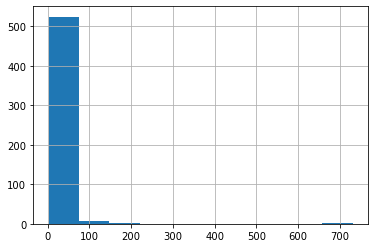

In [74]:
#visualize a histogram of the cluster size

shs_count['whiskey_id'].hist()

plt.show()

In [75]:
#stats about cluster size in the shs clusters
shs_count['whiskey_id'].describe()

count    534.000000
mean      11.048689
std       35.220526
min        2.000000
25%        2.000000
50%        4.000000
75%        9.000000
max      731.000000
Name: whiskey_id, dtype: float64

In [76]:
#stats on the cluster size in hs clusters
hs_ct['whiskey_id'].describe()

count     230.000000
mean       25.652174
std       103.295019
min         5.000000
25%         7.000000
50%        11.500000
75%        22.000000
max      1551.000000
Name: whiskey_id, dtype: float64

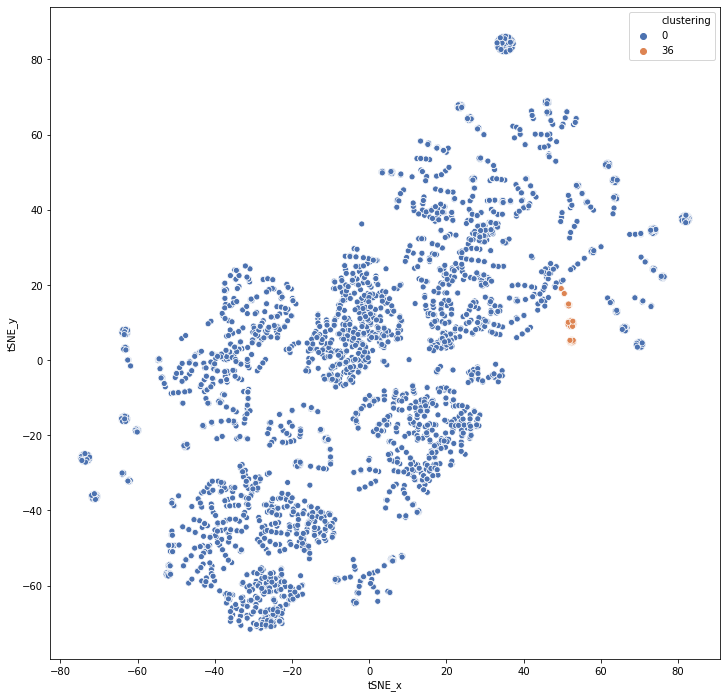

In [77]:
#try a variation where only the cluster is colored, by setting other cluster values than the one targeted to 0
#this can work the same as cluster_vis() but the cluster vector needs to be processed first to make all clusters 0 
# save for the indicated cluster

def vis_ind_clust(dbscan_array, target_cluster, tsne_df):
    
    filt_array = []
    
    for cls in dbscan_array:
        if cls == target_cluster:
            filt_array.append(target_cluster)
        else:
            filt_array.append(0)
    
    vis_1['clustering'] = filt_array
    
    plt.figure(figsize = (12, 12))
    
    #in this sheet vis1 should work as tsne_df
    sns.scatterplot(data = tsne_df, x = 'tSNE_x', y = 'tSNE_y', hue = 'clustering', palette = 'deep')

    plt.show()

# try visualizing cluster 36

vis_ind_clust(cls_20, 36, vis_1)

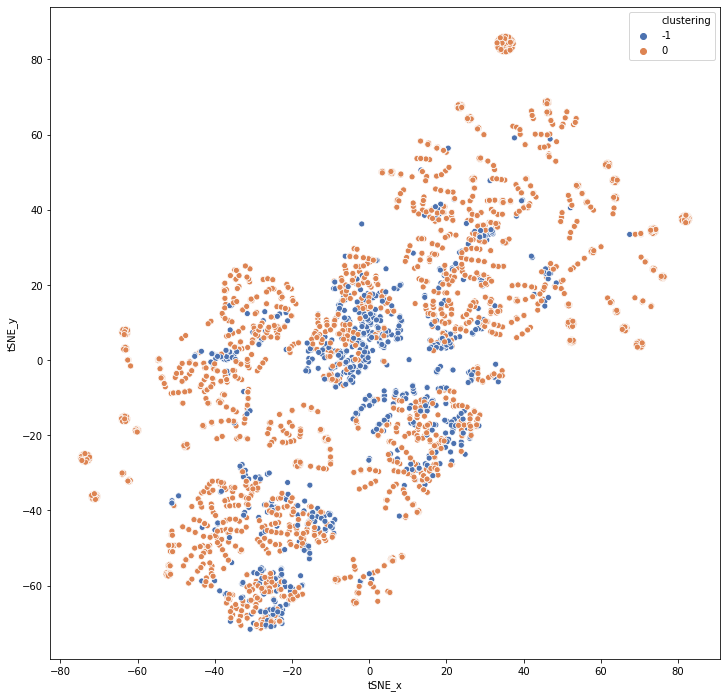

In [78]:
# visualize the noise

vis_ind_clust(cls_20, -1, vis_1)

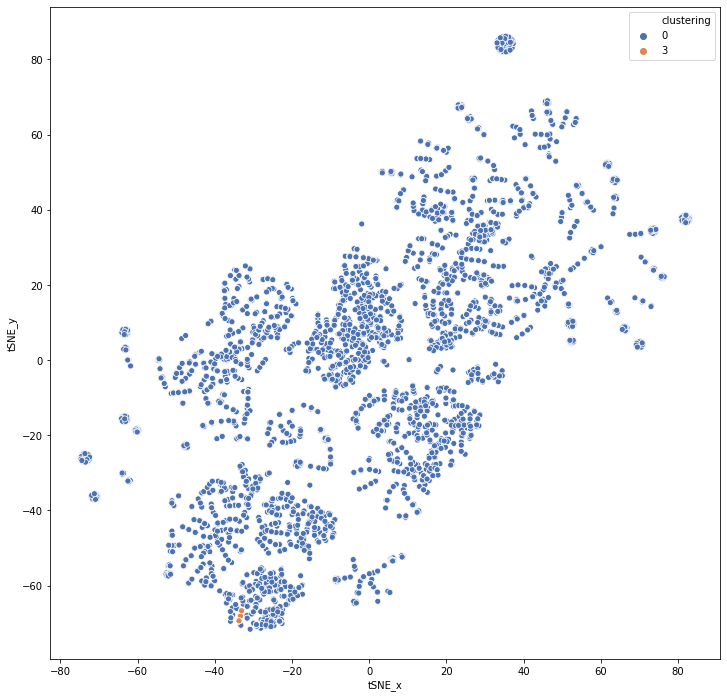

In [79]:
#try to find the large circular cluster - as I think it is a bunch of identical points

vis_ind_clust(cls_20, 3, vis_1)

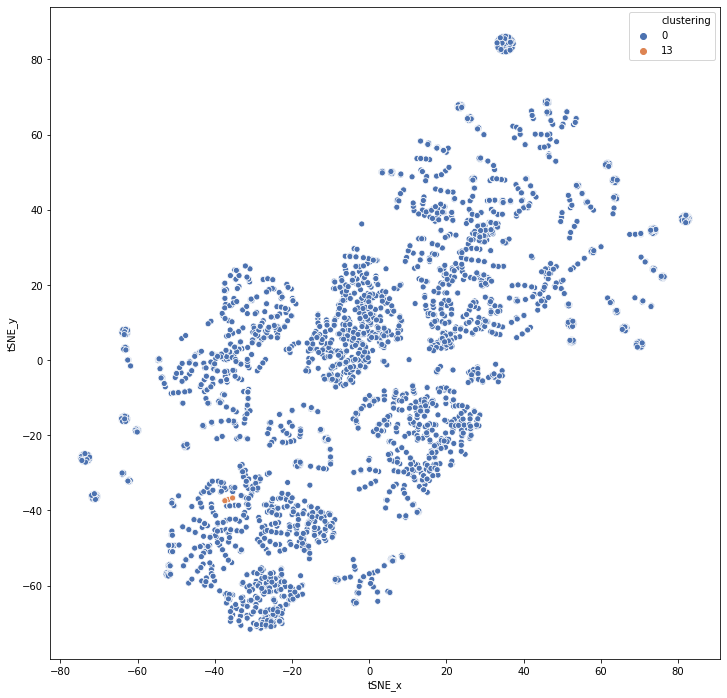

In [80]:
vis_ind_clust(cls_20, 13, vis_1)

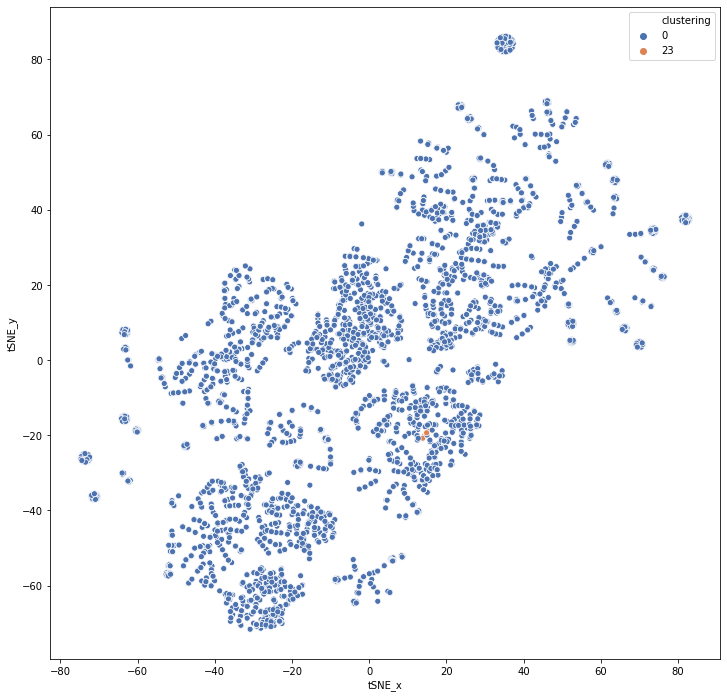

In [81]:
vis_ind_clust(cls_20, 23, vis_1)

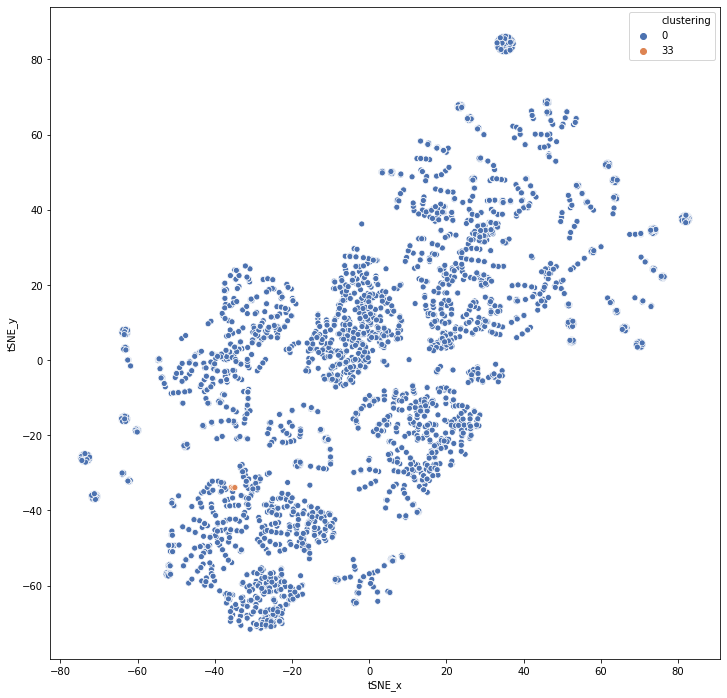

In [82]:
vis_ind_clust(cls_20, 33, vis_1)

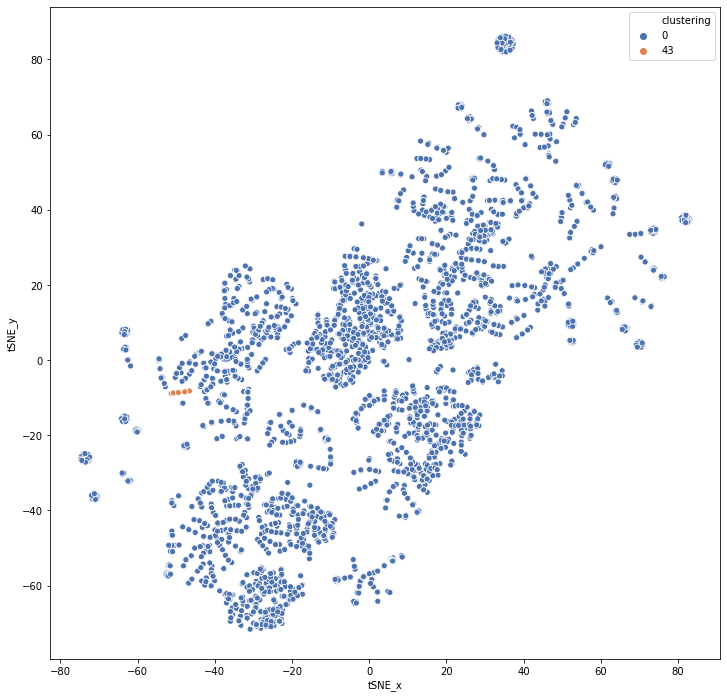

In [83]:
vis_ind_clust(cls_20, 43, vis_1)

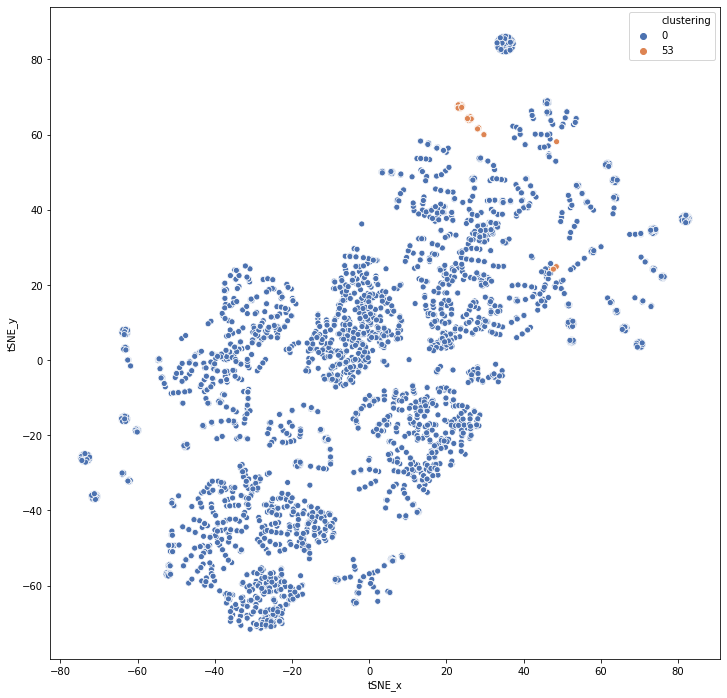

In [84]:
vis_ind_clust(cls_20, 53, vis_1)

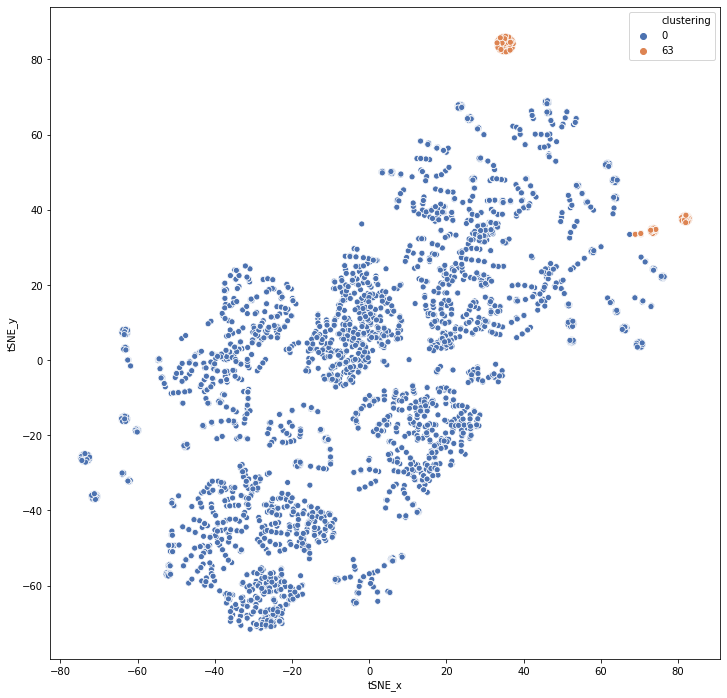

In [85]:
vis_ind_clust(cls_20, 63, vis_1)

In [87]:
c63 = ml_df_shs[ml_df_shs['clustering'] == 63]

c63

whiskey_id  fruity_words  wood_words  spicy_words  sweet_words  \
103          103             0           0            0            0   
105          105             0           0            0            0   
107          107             1           0            0            0   
110          110             1           0            0            0   
129          129             0           0            0            0   
...          ...           ...         ...          ...          ...   
5816        5816             1           0            0            0   
5821        5821             3           0            0            0   
5843        5843             1           0            0            0   
5851        5851             2           0            0            0   
5857        5857             0           0            0            0   

      maillard_words  smoke_words  clustering  \
103                0            0          63   
105                0            0          63   
107                0            0          63   
110                0            0          63   
129                0            0          63   
...              ...          ...         ...   
5816               0            0          63   
5821               0            0          63   
5843               0            0          63   
5851               0            0          63   
5857               0            0          63   

                                                  names  
103               Southern Coast Single Malt Cask 3 46%  
105                         Bakery Hill Double Wood 46%  
107                  Old Hobart Overeem Sherry Cask 55%  
110                    Old Hobart Overeem Port Cask 55%  
129      Belgian Owl Cask 4276140 5 year old 2012 76.1%  
...                                                 ...  
5816                      Penderyn Portwood Batch 2 41%  
5821                             Penderyn Portwood  41%  
5843  Low Gap Whiskey (American Craft Whiskey Distil...  
5851                             Koval Levant Spelt 40%  
5857                             Koval American Oat 40%  

[179 rows x 9 columns]